# Fragment calculation for a water dimer
The aim of this lesson is to present how to do basic fragment calculations with BigDFT and explain how to do to basic calculations. It is recommended that you have read [the relevant papers in articles describing BigDFT](http://bigdft.org/Wiki/index.php?title=Articles_describing_BigDFT) and go through [the tutorials on linear-scaling BigDFT](http://bigdft.org/Wiki/index.php?title=Category:Tutorials) before beginning.

**Import useful modules and functions**

In [1]:
from __future__ import print_function
import os
import sys
#import commands #Deprecated module, use subprocess instead
import subprocess
import shutil
import tarfile
from futile.Utils import find_files
try:
    from BigDFT import Logfiles as lf
except ImportError:
    sys.path.append('/Users/maximemoriniere/post-doc/bigdft/bigdft/bigdft/src/python')
    from BigDFT import Logfiles as lf
import matplotlib.pyplot as plt

## Template calculation

<img src="http://bigdft.org/images/1/19/H2o_dimer.png">
We consider the example of a water dimer with varying separation R between the molecules. Since we have two identical water molecules, they can both be represented by the same template fragment. The first step is therefore to generate the support functions for an isolated water molecule. We will use the following h2o.xyz and h2o.yaml input files: 

In [2]:
h2o_xyz = """\
3 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371"""

h2o_yaml = """\
 import: linear
 dft:
   hgrids: {hgrids}
   rmult: [5.0, 7.0]
   inputpsiid: linear
   ixc: LDA (ABINIT)
 lin_general:
   output_wf: 1
   output_mat: 11
 lin_kernel:
   alphamix: 0.3
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: {On}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: {Hn}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
"""

Note the non-zero values for output_wf and output_mat, which specify that the support functions and associated matrices be written to file. You should also observe that we have chosen a rather small value for hgrid, which will ensure a more accurate interpolation when the support functions are roto-translated.

Fragment calculations require the template information to be in a sub-directory, so you should proceed to run BigDFT in the following manner: 

In [3]:
# Define the variables to run a calculation
BigDFT = os.environ["BIGDFT_ROOT"]+"/bigdft"
if not os.path.exists(BigDFT):
    BigDFT = "/Users/maximemoriniere/post-doc/bigdft/bigdft/build/bigdft/src/bigdft"
os.environ["OMP_NUM_THREADS"]="4" # Depends on your computer (compiled with OpenMP)

In [4]:
# Define the functions allowing to run a BigDFT calculation
def collect_templates_data(input_name, templates_dir):
    """
    Function collecting the data of the templates required by the 
    input file input_name. Symbolic links to the input files 
    of the templates and a copy of the data-template folder is done. 
    The path to the templates data is given by templates_dir.

    :param input_name: Name of the input file.
    :type input_name: str
    :param templates_dir: Path to the templates.
    :type templates_dir: str
    """
    from futile import Yaml
    
    # Read the input file to get the names of the required templates
    input_file = Yaml.yaml.load(open(input_name, 'r').read())
    templates = [template for template in input_file['frag']]
    
    # Raise an error if a required template is missing from templates_dir
    if templates_dir is None:
        raise ValueError("A value should be given to templates_dir.")
        
    # Find if some templates are missing in the templates folder
    missing_templates = [template for template in templates 
                         if ['data-'+template, template+".yaml", template+".xyz"]
                         not in os.listdir(templates_dir)]
    try:
        assert missing_templates == []
    except AssertionError:
        raise ValueError("Missing template(s): {}".format(missing_templates))
        
    # Create ang go to a folder containing the data of all the templates
    data_folder = 'data-'+input_name[:-5]
    if data_folder not in os.listdir(os.getcwd()): os.mkdir(data_folder)
    os.chdir(data_folder)
    
    # Create the needed symlinks: data folder, and input and posinp files
    for template in templates:
        # Create the symlink to the template input files
        for f in [template+".yaml", template+".xyz"]:
            if f in os.listdir(os.getcwd()):
                os.remove(f)
            os.symlink(templates_path+"/"+f, f)
        # Copy the whole data-template folder
        data_template = 'data-'+template
        shutil.copytree(templates_path+"/"+data_template, data_template)
    
    # Don't forget to go back to the previous folder
    os.chdir("..")
    
def run_bigdft(yaml, xyz, prefix=None, templates_dir=None):
    """
    This function runs a bigdft calculation if it was not already performed.
    
    :param prefix: Prefix of the calculation to define the input files.
    :type prefix: str
    :param yaml: Content of the input file
    :type yaml: str
    :param xyz: Content of the posinp file
    :type xyz: str
    :param templates_dir: For fragment calculation : path to the templates 
                          (optional, default to None).
    :type templates_dir: str
    """
    # Initialise some variables
    if prefix is not None:
        input_name  = prefix+".yaml"    # input file name
        output_name = "log-"+input_name # output file name
        posinp_name = prefix+".xyz"     # posinp file name
        command = [BigDFT, prefix]
    else:
        input_name  = "input.yaml" # input file name
        output_name = "log.yaml"   # output file name
        posinp_name = "posinp.xyz" # posinp file name
        command = [BigDFT]
        
    # Check that the calculation was not already done
    if not os.path.exists(output_name):
        # Write the input file
        open(input_name, "w").write(yaml)
        # Collect the data required for a fragment calculation
        if " frag:" in yaml:
            collect_templates_data(input_name, templates_dir)
        # Write the posinp file
        open(posinp_name, "w").write(xyz)
        # Launch the calculation
        print(prefix, command, "...")
        run = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        out, err = run.communicate()
        print(out)
    else:
        print("Logfile {} already exists!".format(output_name))

In [5]:
# Initialize some names
start_path = os.getcwd()       # Path to the current folder
templates_folder = "templates" # Name of the templates folder
templates_path = start_path+"/"+templates_folder # Path to the templates folder

# Extract the output files from an archive
tarname = 'H2O_dimer.tgz'
if os.path.exists(tarname):
    print("Extract {} to avoid calculating every point of the dissociation curves.".format(tarname))
    with tarfile.open(tarname,"r:bz2") as tar:
        tar.extractall()

# Extract the archive containing the templates, if it exists
tartemplate = templates_folder+".tgz"
if os.path.exists(tartemplate):
    print("Extract {} to avoid calculating the templates.".format(tarname))
    with tarfile.open(tartemplate,"r:bz2") as tar:
        tar.extractall()
# Else, create the templates folder and compute one template
else:
    if templates_folder not in os.listdir(start_path):
        os.mkdir(templates_folder)
    os.chdir(templates_folder)
    # Run the template of the H2O molecule
    try:
        template_yaml = h2o_yaml.format(hgrids="0.25", Hn="1", On="4")
        run_bigdft(template_yaml, h2o_xyz, prefix="h2o")
    finally:
        os.chdir("..")

h2o ['/Users/maximemoriniere/post-doc/bigdft/bigdft/build/bigdft/src/bigdft', 'h2o'] ...
 <BigDFT> log of the run will be written in logfile: ./log-h2o.yaml



At the end of the calculation, you will notice that another directory data-h2o been created by BigDFT, which contains a number of files for the support functions and matrices. With these outputs, we can proceed to do a fragment calculation. 

## Fragment calculations
We will consider three different scenarios for the dimer: 
* with the molecules at a short separation, 
* close to the equilibrium, and 
* far apart.

Note that in each case, we keep the molecules rigid, with neither the isolated or dimer system in a fully relaxed state, as this is only intended to serve as a model system. We therefore have three position inputs: dimer_1.5.xyz, dimer_2.0.xyz and dimer_5.0.xyz: 

In [6]:
def dimer_xyz(d):
    x1 = d
    x2 = d + 0.296831000000
    x3 = d + 0.273536000000
    d_xyz = """\
6 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371
O             {0:14.12f}           -0.003706000000            0.113495000000
H             {1:14.12f}            0.762122000000           -0.351887000000
H             {2:14.12f}           -0.747744000000           -0.399151000000"""
    return d_xyz.format(x1,x2,x3)

dists = [1.5,2.0,5.0]
print(dimer_xyz(dists[0]))

6 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371
O             1.500000000000           -0.003706000000            0.113495000000
H             1.796831000000            0.762122000000           -0.351887000000
H             1.773536000000           -0.747744000000           -0.399151000000


We of course also need a *dimer.yaml* input file: 

In [7]:
dimer_yaml = """\
 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   inputpsiid: linear_restart
   ixc: LDA (ABINIT)
 lin_general:
   nit: 1
   kernel_restart_mode: kernel
   output_wf: 1
   output_mat: 1
   output_coeff: 1
   calc_dipole: Yes
   subspace_diag: Yes
 lin_basis:
   nit: 1
 lin_kernel:
   nit: [20,100]
   alphamix: 0.3
   rpnrm_cv: 1.0E-010
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: {On}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: {Hn}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
"""

frag_yaml = """\
 frag:
   {name}: [1, 2]
"""

Compared to a standard linear-scaling calculation, there are not many big changes to the input. You will of course notice that we have specified that this is a restart calculation via the *inputpsiid* variable, and we have allowed for a large number of kernel iterations while **eliminating basis optimization by setting _nit_ to 1** in the *lin_basis* block.

Most importantly, we have also **added a frag block**, which is where we we specify the number of fragments and their types. In this example it is straightforward, as we simply have two fragments of the same name. More complicated systems are of course also possible, as will be seen in later examples.

**Exercise**: Using the above inputs, run fragment calculations for the three different coordinates. Make sure that you rename the files appropriately for each calculation, so that the **yaml, xyz and data** have the same label, either by copying files or using symbolic links **in this case the file _h2o.xyz_ and the directory _data-h2o_ into the directory _data-xxx_**.
Also run all three systems without fragments; you can reuse the file for generating the template support functions if you change hgrids to 0.35 and switch off the output of the support functions and other associated quantities.

In [8]:
def run_setup(folder, distances, yaml, xyz_func, templates_dir=None):
    """
    Function that creates all the folders and files for a given setup.
    A setup is defined by a folder name, created to store all the results
    obtained using a given yaml file but for different distances.
    It loops over all the distances to create a folder for each distance
    and then is nothing but a wrapper over the run_bigdft method
    """
    # - Create and go to the folder of the setup
    if folder not in os.listdir(os.getcwd()): os.mkdir(folder)
    os.chdir(folder)
    
    # - Loop over the distances 
    #  (Both finally are here to make sure that the os.chdir("..") command
    #   is performed even if there is an interruption or an error.)
    prefix = "dimer"
    try:
        for d in dists:
            print(folder, "dist =", d)
            # - Create and go to a subfolder for the current distance
            subfolder = prefix+"_"+str(d)
            if subfolder not in os.listdir(os.getcwd()): os.mkdir(subfolder)
            os.chdir(subfolder)
            # - Run the calculation
            try:
                run_bigdft(yaml, xyz_func(d), prefix=prefix, \
                           templates_dir=templates_dir)
            finally:
                os.chdir("..")
    finally:
        os.chdir("..") 

In [9]:
# Make sure to start from the right folder
os.chdir(start_path) 

# Create and go to a folder that will contain different types of calculations
dimer_folder = "H2O_dimer"
dimer_path = start_path+"/"+dimer_folder
if dimer_folder not in os.listdir(os.getcwd()): os.mkdir(dimer_folder)
os.chdir(dimer_folder)

# Fragments calculations:
input_frag_yaml = dimer_yaml.format(Hn="1", On="4") + frag_yaml.format(name='h2o')
run_setup("fragment_1-4", dists, input_frag_yaml, dimer_xyz, 
          templates_dir=templates_path)

# Linear calculations using hgrids=0.35:
# - Use the same input file as the template with a larger hgrid,
#   the posinp file being given by dimer_xyz.
# - No templates to use: no need to define templates_dir in run_setup
input_lin_yaml = h2o_yaml.format(hgrids="0.35", Hn="1", On="4")
run_setup("linear_1-4", dists, input_lin_yaml, dimer_xyz)

fragment_1-4 dist = 1.5
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 2.0
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 5.0
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 1.5
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 2.0
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 5.0
Logfile log-dimer.yaml already exists!


Compare the linear and fragment energies for the three different distances. You will notice that they are very similar for the large separation where the molecules are weakly interacting, with a moderate error for the equilibrium calculation and a very large error for the short distance. This is unsurprising, as the fragment approach is intended for well separated molecules and is expected to break down at small distances. In other terms, the basis set superposition error (BSSE) is large. When using the fragment approach it is therefore important to consider whether the approximation that it represents is valid in your case.

In [10]:
dimer_logs = find_files('*_1-4/dimer_*/log-dimer.yaml')
for logfile in dimer_logs:
    log = lf.Logfile(logfile)
    print(logfile+": "+str(log.energy))

fragment_1-4/dimer_1.3/log-dimer.yaml: -34.3271488376
fragment_1-4/dimer_1.4/log-dimer.yaml: -34.3453064988
fragment_1-4/dimer_1.5/log-dimer.yaml: -34.3565602129
fragment_1-4/dimer_1.6/log-dimer.yaml: -34.3633710714
fragment_1-4/dimer_1.7/log-dimer.yaml: -34.3671467526
fragment_1-4/dimer_1.8/log-dimer.yaml: -34.3690889207
fragment_1-4/dimer_1.9/log-dimer.yaml: -34.3697566824
fragment_1-4/dimer_2.0/log-dimer.yaml: -34.3697461737
fragment_1-4/dimer_2.1/log-dimer.yaml: -34.3692562092
fragment_1-4/dimer_2.2/log-dimer.yaml: -34.3685822264
fragment_1-4/dimer_2.3/log-dimer.yaml: -34.3677893991
fragment_1-4/dimer_2.4/log-dimer.yaml: -34.3669863449
fragment_1-4/dimer_2.5/log-dimer.yaml: -34.3662219449
fragment_1-4/dimer_3.0/log-dimer.yaml: -34.3632988463
fragment_1-4/dimer_3.5/log-dimer.yaml: -34.3617942524
fragment_1-4/dimer_4.0/log-dimer.yaml: -34.3610317302
fragment_1-4/dimer_4.5/log-dimer.yaml: -34.3605686241
fragment_1-4/dimer_5.0/log-dimer.yaml: -34.3603330013
linear_1-4/dimer_1.3/log-dim

## Increasing the basis

Nonetheless, let us assume that in this case we insist on using the fragment approach. What can we do to improve the accuracy? One option is to increase the number of degrees of freedom by increasing the number of support functions per atom. Let's try adding another s-type support function to each atom. Returning to the template calculation:

In [11]:
# Go to the templates directory
os.chdir(templates_path)

Change nbasis to 2 for hydrogen and 5 for oxygen. Whenever we vary the number of support functions from the default values, we have to specify the electronic configuration. To do this, add the following block to the end of the input file: 

In [12]:
# occupation block
ig_25_yaml="""\
 ig_occupation:
   H:
     1s: 1.0
     2s: 0.0
   O:
     2s: 2.0
     2p: [4/3, 4/3, 4/3]
     3s: 0.0
"""

# Define the input file:
template_25_yaml = h2o_yaml.format(hgrids="0.25", Hn="2", On="5") + ig_25_yaml

Rerun the template calculation in the templates directory, copying the input files to h2o_25.yaml and h2o_25.xyz to avoid overwriting the previous template support functions. This will produce a directory called data-h2o_25 containing the relevant outputs. You will notice that the energy is virtually the same as for a smaller basis, as we already had enough degrees of freedom to represent the isolated molecule.

In [13]:
# Run the template calculation
run_bigdft(template_25_yaml, h2o_xyz, prefix="h2o_25")

Logfile log-h2o_25.yaml already exists!


We can now go back to the folder where we performed the first fragment calculations, to run a new setup of fragment calculations by modifying the fragment block. Do not forget to change both the values of nbasis in the input file and to add the occupation block at the end of the input file: 

In [14]:
# Go to the dimer folder
os.chdir(dimer_path)

# Define the input file
frag_25_yaml = frag_yaml.format(name='h2o_25') # Modify the fragment block
input_25_yaml = dimer_yaml.format(Hn="2", On="5") + frag_25_yaml + ig_25_yaml

Once we update these values, BigDFT should run successfully. Note that for rloc, we do not have to make sure the radii is the same as the template calculation, BigDFT will simply override the input value and detect the correct template radius. 

In [15]:
# Fragments calculations (2-5) for the three distances
run_setup("fragment_2-5", dists, input_25_yaml, dimer_xyz, 
          templates_dir=templates_path)

fragment_2-5 dist = 1.5
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 2.0
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 5.0
Logfile log-dimer.yaml already exists!


## Exercise: 

Try increasing the number of support functions further. What happens to the energies? If you want some further practice, try more distances and see if you can reproduce the binding curve (see below).

<img style="float: left;", src="http://bigdft.org/images/b/b1/H2o_binding.png">

## Answer to the exercise
First of all, we construct the array of te required distances.

In [16]:
import numpy as np
dists = [i for i in np.arange(1.3,2.5,0.1)] + [i for i in np.arange(2.5,5.5,0.5)]

Now we run the fragment calculations with *nbasis=1* for hydrogen atoms and *nbasis=4* for oxygen atoms:

In [17]:
run_setup("fragment_1-4", dists, input_frag_yaml, dimer_xyz, 
          templates_dir=templates_path)

fragment_1-4 dist = 1.3
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 1.4
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 1.5
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 1.6
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 1.7
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 1.8
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 1.9
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 2.0
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 2.1
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 2.2
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 2.3
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 2.4
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 2.5
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 3.0
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 3.5
Logfile log-dimer.yaml already exists!
fragment_1-4 dist = 4.0
Logfile log-dimer.yaml already 

The fragment calculations with *nbasis=2* for hydrogen atoms and *nbasis=5* for oxygen atoms are performed similarly:

In [18]:
run_setup("fragment_2-5", dists, input_25_yaml, dimer_xyz, 
          templates_dir=templates_path)

fragment_2-5 dist = 1.3
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 1.4
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 1.5
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 1.6
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 1.7
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 1.8
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 1.9
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 2.0
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 2.1
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 2.2
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 2.3
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 2.4
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 2.5
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 3.0
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 3.5
Logfile log-dimer.yaml already exists!
fragment_2-5 dist = 4.0
Logfile log-dimer.yaml already 

We now want to perform fragment calculations with *nbasis=5* for hydrogen atoms and *nbasis=8* for oxygen atoms. The first step is to run the template with the according nbasis values. Don't forget to change the occupation block.

In [19]:
# Go to the templates directory
os.chdir(templates_path)

# Define the input file (with a new occupation block)
ig_58_yaml="""\
 ig_occupation:
   H:
     1s: 1.0
     2s: 0.0
     2p: [0., 0., 0.]
   O:
     2s: 2.0
     2p: [4/3, 4/3, 4/3]
     3s: 0.0
     3p: [0., 0., 0.]
"""
input_yaml = h2o_yaml.format(hgrids="0.25", Hn="5", On="8") + ig_58_yaml

# Run the calculation
run_bigdft(input_yaml, h2o_xyz, prefix="h2o_58")

Logfile log-h2o_58.yaml already exists!


The fragment calculation can now be performed. Don't forget to use modify the fragment block and to use the new occupation block:

In [20]:
# Go back to the dimer directory
os.chdir(dimer_path) 

# Define the input file (with the new fragment and occupation blocks)
frag_58_yaml = frag_yaml.format(name='h2o_28')
input_58_yaml = dimer_yaml.format(Hn="5", On="8") + frag_58_yaml + ig_58_yaml

# Then run the setup for all distances -- 15 calculations to be done 
run_setup("fragment_5-8", dists, input_58_yaml, dimer_xyz, 
          templates_dir=templates_path)

fragment_5-8 dist = 1.3
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 1.4
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 1.5
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 1.6
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 1.7
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 1.8
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 1.9
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 2.0
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 2.1
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 2.2
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 2.3
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 2.4
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 2.5
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 3.0
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 3.5
Logfile log-dimer.yaml already exists!
fragment_5-8 dist = 4.0
Logfile log-dimer.yaml already 

We also have to perform the linear calculations for all the distances:

In [21]:
run_setup("linear_1-4", dists, input_lin_yaml, dimer_xyz)

linear_1-4 dist = 1.3
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 1.4
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 1.5
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 1.6
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 1.7
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 1.8
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 1.9
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 2.0
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 2.1
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 2.2
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 2.3
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 2.4
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 2.5
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 3.0
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 3.5
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 4.0
Logfile log-dimer.yaml already exists!
linear_1-4 dist = 4.5
Lo

Finally, we perform the calculations using the cubic version of BigDFT:

In [22]:
#Define the input file
cubic_yaml = """\
 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   ixc: LDA (ABINIT)"""

# Run the cubic calculations
run_setup("cubic", dists, cubic_yaml, dimer_xyz)

cubic dist = 1.3
Logfile log-dimer.yaml already exists!
cubic dist = 1.4
Logfile log-dimer.yaml already exists!
cubic dist = 1.5
Logfile log-dimer.yaml already exists!
cubic dist = 1.6
Logfile log-dimer.yaml already exists!
cubic dist = 1.7
Logfile log-dimer.yaml already exists!
cubic dist = 1.8
Logfile log-dimer.yaml already exists!
cubic dist = 1.9
Logfile log-dimer.yaml already exists!
cubic dist = 2.0
Logfile log-dimer.yaml already exists!
cubic dist = 2.1
Logfile log-dimer.yaml already exists!
cubic dist = 2.2
Logfile log-dimer.yaml already exists!
cubic dist = 2.3
Logfile log-dimer.yaml already exists!
cubic dist = 2.4
Logfile log-dimer.yaml already exists!
cubic dist = 2.5
Logfile log-dimer.yaml already exists!
cubic dist = 3.0
Logfile log-dimer.yaml already exists!
cubic dist = 3.5
Logfile log-dimer.yaml already exists!
cubic dist = 4.0
Logfile log-dimer.yaml already exists!
cubic dist = 4.5
Logfile log-dimer.yaml already exists!
cubic dist = 5.0
Logfile log-dimer.yaml already 

We can now collect the relevant data from the logfiles: the energies and distances, are stored as values of a dictionary of data. There is one dictionary for each setup. The are listed in the variable *curves*.

In [23]:
HatoeV = 27.211396132 #Hartree to eV conversion factor
setups = ['cubic', 'linear_1-4', 'fragment_1-4', 'fragment_2-5', 'fragment_5-8']
curves = []
for setup in setups:
    #lfiles = glob.glob('log-dimer-*-%s.yaml' % name)
    logs = find_files(setup+"/dimer_*/log-dimer.yaml")
    logs.sort()
    data = {'distances': [], 'energies': [], 'legend': setup}
    for logname in logs:
        #print fname
        log = lf.Logfile(logname)
        data['distances'].append(log.log['posinp']['positions'][3]['O'][0])
        data['energies'].append(log.energy)
    if len(data['energies']) > 0:
        eref = data['energies'][-1]
        data['energies'] = [ HatoeV*(e-eref) for e in data['energies'] ]
        #print data['energies']
    curves.append(data)

We finally use matplotlib to plot the dissociation curves:

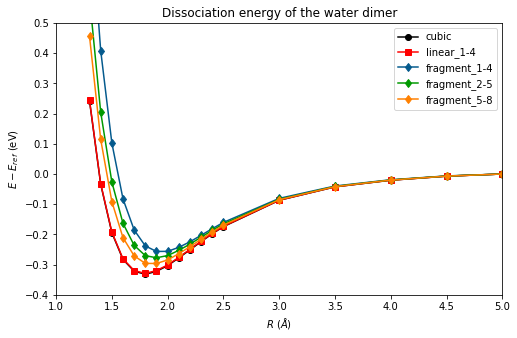

In [24]:
# Lists of markers and colors (for matplotlib)
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o', 's', 'd', 'd', 'd']

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i])
plt.ylim([-0.4, 0.5])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend(loc=0)
plt.show()

This finishes this exercise: the asked curve is reproduced.

<img style="float: left;", src="http://bigdft.org/images/b/b1/H2o_binding.png">

## Create archives

To avoid running all calculations when running this notebook again, we create two archives as tar files:

* one containing all logs _log-dimer*_ and all input files *dimer.yaml* and positions *dimer.xyz* for each setup,

* another one containing all data for the templates (output and input files _\*h2o.\*_ plus the folders _data-h2o*_)

In [27]:
# Go back to the starting folder, with both templates and dimer folders
os.chdir(start_path)

# Create an archive with logs and input files for each setup
if not os.path.exists(tarname):
    tar = tarfile.open(tarname, "w:bz2")
    for setup in setups:
        logfiles = find_files(dimer_folder+"/"+setup+"/dimer_*/log-dimer*.yaml")
        input_files = find_files(dimer_folder+"/"+setup+"/dimer_*/dimer.yaml")
        posinp_files = find_files(dimer_folder+"/"+setup+"/dimer_*/dimer.xyz")
        for name in logfiles + input_files + posinp_files:
            tar.add(name)
    tar.close()
    print("Creation of a tar file with all log files: {}".format(tarname))
else:
    print("No creation of tarfile {} because it already exists!".format(tarname))

# Create a second archive with templates data
if not os.path.exists(tartemplate):
    tar = tarfile.open(tartemplate, "w:bz2")
    templates = ['h2o', 'h2o_25', 'h2o_58']
    for template in templates:
        data_folders = [templates_folder+'/data-'+template+"/"+f 
                        for f in find_files(templates_folder+'/data-'+template)]
        logfiles = find_files(templates_folder+"/log-"+template+".yaml")
        input_files = find_files(templates_folder+"/"+template+".yaml")
        posinp_files = find_files(templates_folder+"/"+template+".xyz")
        for name in data_folders + logfiles + input_files + posinp_files:
            tar.add(name)
    tar.close()
    print("Creation of a tar file with all log files: {}".format(tartemplate))
else:
    print("No creation of tarfile {} because it already exists!".format(tartemplate))

No creation of tarfile H2O_dimer.tgz because it already exists!
No creation of tarfile templates.tgz because it already exists!
